In [6]:
import json
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime

with open("user-wallet-transactions.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

df["wallet"] = df["userWallet"]
df["action"] = df["action"].str.lower()
df["amount"] = df["actionData"].apply(lambda x: float(x["amount"]) if x else 0)
df["price_usd"] = df["actionData"].apply(lambda x: float(x["assetPriceUSD"]) if x else 1.0)
df["amount_usd"] = df["amount"] * df["price_usd"]
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s')

#  Group by wallet to generate features
grouped = df.groupby("wallet")

features = []

for wallet, group in grouped:
    total_deposit = group[group["action"] == "deposit"]["amount_usd"].sum()
    total_borrow = group[group["action"] == "borrow"]["amount_usd"].sum()
    total_repay = group[group["action"] == "repay"]["amount_usd"].sum()
    redeem = group[group["action"] == "redeemunderlying"]["amount_usd"].sum()

    repay_ratio = total_repay / total_borrow if total_borrow > 0 else 0
    redeem_ratio = redeem / total_deposit if total_deposit > 0 else 0

    unique_assets = group["actionData"].apply(lambda x: x["assetSymbol"] if x else None).nunique()
    tx_count = group.shape[0]
    active_days = group["timestamp"].dt.date.nunique()
    avg_txn_value = group["amount_usd"].mean()

    features.append({
        "wallet": wallet,
        "total_deposit": total_deposit,
        "total_borrow": total_borrow,
        "total_repay": total_repay,
        "repay_ratio": repay_ratio,
        "redeem_ratio": redeem_ratio,
        "unique_assets": unique_assets,
        "tx_count": tx_count,
        "active_days": active_days,
        "avg_txn_value": avg_txn_value,
    })

wallet_df = pd.DataFrame(features).fillna(0)

# Normalize the features
feature_cols = [
    "total_deposit", "total_borrow", "total_repay",
    "repay_ratio", "redeem_ratio", "unique_assets",
    "tx_count", "active_days", "avg_txn_value"
]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(wallet_df[feature_cols])

# use KMeans clustering as it is a unsuperivised learning
kmeans = KMeans(n_clusters=5, random_state=42)
wallet_df["cluster"] = kmeans.fit_predict(X_scaled)

#  Score assignment based on cluster quality
# Higher repay ratio, more activity means better score
cluster_health = wallet_df.groupby("cluster")[[
    "repay_ratio", "redeem_ratio", "active_days", "total_deposit"
]].mean().sum(axis=1)

# Ranking the clusters
cluster_rank = cluster_health.rank(method="first").astype(int)
cluster_score_map = {
    cluster: int(((rank - 1) / 4) * 800 + 100)  # 100–900 spread
    for cluster, rank in cluster_rank.items()
}

wallet_df["credit_score"] = wallet_df["cluster"].map(cluster_score_map)


wallet_df[["wallet", "credit_score", "cluster"] + feature_cols].to_csv("wallet_credit_scores.csv", index=False)
print(" Credit scores saved to 'wallet_credit_scores.csv'")


 Credit scores saved to 'wallet_credit_scores.csv'


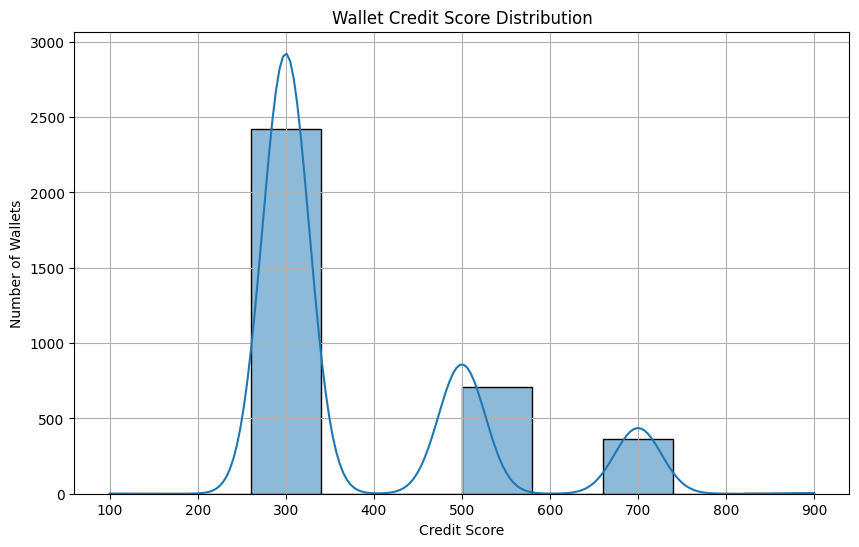

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("wallet_credit_scores.csv")

plt.figure(figsize=(10,6))
sns.histplot(df['credit_score'], bins=10, kde=True)
plt.title("Wallet Credit Score Distribution")
plt.xlabel("Credit Score")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.show()
